In [7]:
from os import listdir
from os.path import isfile, join
import networkx as nx
import collections
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import math
from scipy.sparse.linalg import eigsh
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
def gen_graph(cur_n, g_type,seed=None):
    random.seed(seed)
    if g_type == 'erdos_renyi':
        #print(random.uniform(0.15,0.20))
        g = nx.erdos_renyi_graph(n=cur_n, p=random.uniform(0.15,0.20),seed = seed)
    elif g_type == 'powerlaw':
        g = nx.powerlaw_cluster_graph(n=cur_n, m=random.randint(2,4), p=random.uniform(0.1,0.5),seed = seed)
    elif g_type == 'small-world':
        #print(random.randint(2,5),random.uniform(0.1,0.2))
        g = nx.newman_watts_strogatz_graph(n=cur_n, k=random.randint(2,5), p=random.uniform(0.1,0.2),seed = seed)
    elif g_type == 'barabasi_albert':
        #print(random.randint(2,5))
        g = nx.barabasi_albert_graph(n=cur_n, m=random.randint(2,5),seed = seed)
    elif g_type == 'geometric':
        g = nx.random_geometric_graph(cur_n, random.uniform(0.1,0.4),seed = seed)
    return g
    
def get_from_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
    return data
def gen_new_graphs(graph_type,seed = None):
    random.seed(seed)
    np.random.seed(seed)
    a = np.random.choice(graph_type) if len(graph_type) !=1 else graph_type[0]
    number_nodes = 30
    graph = gen_graph(number_nodes, a,seed)
    #graph =add_super_node(graph)
    active = 1
    nx.set_node_attributes(graph,active, "active")
    return graph   
def input_graph(graph_path,file):
    fh = open(graph_path+str(file), "rb")
    GRAPH = nx.read_edgelist(fh)
    fh.close()
    nodes = GRAPH.nodes()
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = nx.relabel_nodes(GRAPH, map)
    GRAPH.remove_edges_from(nx.selfloop_edges(GRAPH))
    return GRAPH, map


In [8]:
def molloy_reed(g):
  all_degree =   np.array(g.degree())[:,1]
  degs = np.delete(all_degree,-1)
  k = degs.mean()
  k2 = np.mean(degs ** 2)
  beta = k2/k
  return beta
def global_feature(g): 
    feature = {}
    M = len(g.edges())
    N = len(g)
    degs =   np.array(g.degree())[:,1]
    min_k = np.min(degs)
    
    k1 = degs.mean()
    k2 = np.mean(degs** 2)
    div = k2 - k1**2
    A = nx.to_scipy_sparse_array(g, weight='weight',dtype=float,format='csr')
    adj_lams = np.sort(eigsh(A, k=N-1, which='LA', return_eigenvectors=False))
    feature["nodes"] = N
    feature["edges"] = M
    feature["averagedegree"] = k1
    feature["heterogeneity"] = div/k1
    feature["density"] = (2*M)/(N*(N-1))
    feature["resilience"] = molloy_reed(g)
    #power_law_exponent = 1 + N / sum(np.log(degs/min_k))
    feature["modularity"] = nx_comm.modularity(g,nx_comm.label_propagation_communities(g))
    try:
        varepsilons = nx.algorithms.distance_measures.eccentricity(g).values()
        feature["eccentricity"]=  np.mean(list(varepsilons))
        feature["diameter"] = nx.algorithms.distance_measures.diameter(g)
        feature["radius"] = nx.algorithms.distance_measures.radius(g)
    except:
        lcc = max(nx.connected_components(g), key=len)
        subGraph = g.subgraph(lcc)
        varepsilons = nx.algorithms.distance_measures.eccentricity(subGraph).values()
        feature["eccentricity"]=  np.mean(list(varepsilons))
        feature["diameter"] = nx.algorithms.distance_measures.diameter(subGraph)
        feature["radius"] = nx.algorithms.distance_measures.radius(subGraph)
    feature["spectral_radius"]=adj_lams[-1]
    feature["spectral_gap"]=  adj_lams[-1]-adj_lams[-2]
    feature["natural_connectivity"]= np.log2(sum(np.exp(np.real(adj_lams)))/len(adj_lams))
    feature["global_efficiency"] = nx.algorithms.efficiency_measures.global_efficiency(g)
    feature["assortativity"] = nx.algorithms.assortativity.degree_assortativity_coefficient(g)
    #global_properties =np.hstack((nodes, edges,density,resilience,heterogeneity,power_law_exponent, modularity,eccentricity,diameter,radius,spectral_radius,spectral_gap,natural_connectivity,assortativity))
    return feature
feature = get_from_json("../Dataset/featuresNew.json")

# Synthetic Graph

In [ ]:
graph_path= ["../Dataset/SyntheticGraph/Degree/","../Dataset/SyntheticGraph/Homogeneity/"]
for path in graph_path:
    file_list = [f for f in listdir(path) if isfile(join(path, f))] 
    for i, graph_name in enumerate(file_list):
        GRAPH, _ = input_graph(path,graph_name)
        feature[graph_name] =  global_feature(GRAPH)
    

# BA with Motifs Attached

In [ ]:
graph_path = "../Dataset/Validation/Motifs_Attached/BA/"
file_list = [f for f in listdir(graph_path) if isfile(join(graph_path, f))] 
for i, graph_name in enumerate(file_list):
    GRAPH, _ = input_graph(graph_path,graph_name)
    feature[graph_name] =  global_feature(GRAPH)

# Tree with Motifs Attached

In [ ]:
graph_path ="../Dataset/Validation/Motifs_Attached/Tree/" 
file_list = [f for f in listdir(graph_path) if isfile(join(graph_path, f))] 
for i, graph_name in enumerate(file_list):
    GRAPH, _ = input_graph(graph_path,graph_name)
    feature[graph_name] =  global_feature(GRAPH)

# Real World Network

In [ ]:
graph_path =  "../Dataset/Real/"
file_list = ["corruption.txt","foodweb-baywet.txt","inf-USAir97.txt","moreno_crime_projected.txt",'opsahl-openflights.txt','household.txt','faa.txt','facebook.txt','powergrid.txt','netscience.txt']#[f.split(".")[0] for f in listdir(graph_path) if isfile(join(graph_path, f))] 
for i, graph_name in enumerate(file_list):
    print(graph_name, end=" ,")
    GRAPH, _ = input_graph(graph_path,graph_name)
    feature[graph_name] =  global_feature(GRAPH)

# Cancer Gene Network

In [ ]:
graph_path = "../Dataset/GeneNetwork/Pair-SSN/"
graph_path = "../Dataset/Motifs_Attached/New_BA/"
file_list = [f for f in listdir(graph_path) if isfile(join(graph_path, f))] 
for i, graph_name in enumerate(file_list):
    GRAPH, _ = input_graph(graph_path,graph_name)
    feature[graph_name] =  global_feature(GRAPH)

In [ ]:
graph_path = "../Dataset/Motifs_Attached/New_Tree/"
file_list = [f for f in listdir(graph_path) if isfile(join(graph_path, f))] 
for i, graph_name in enumerate(file_list):
    GRAPH, _ = input_graph(graph_path,graph_name)
    feature[graph_name] =  global_feature(GRAPH)

In [ ]:
graph_path = "../Dataset/SyntheticGraph/Degree/"
file_list = [f for f in listdir(graph_path) if isfile(join(graph_path, f))] 
for i, graph_name in enumerate(file_list):
    GRAPH, _ = input_graph(graph_path,graph_name)
    feature[graph_name] =  global_feature(GRAPH)

In [ ]:
graph_path = "../Dataset/SyntheticGraph/Homogeneity/"
file_list = [f for f in listdir(graph_path) if isfile(join(graph_path, f))] 
for i, graph_name in enumerate(file_list):
    GRAPH, _ = input_graph(graph_path,graph_name)
    feature[graph_name] =  global_feature(GRAPH)

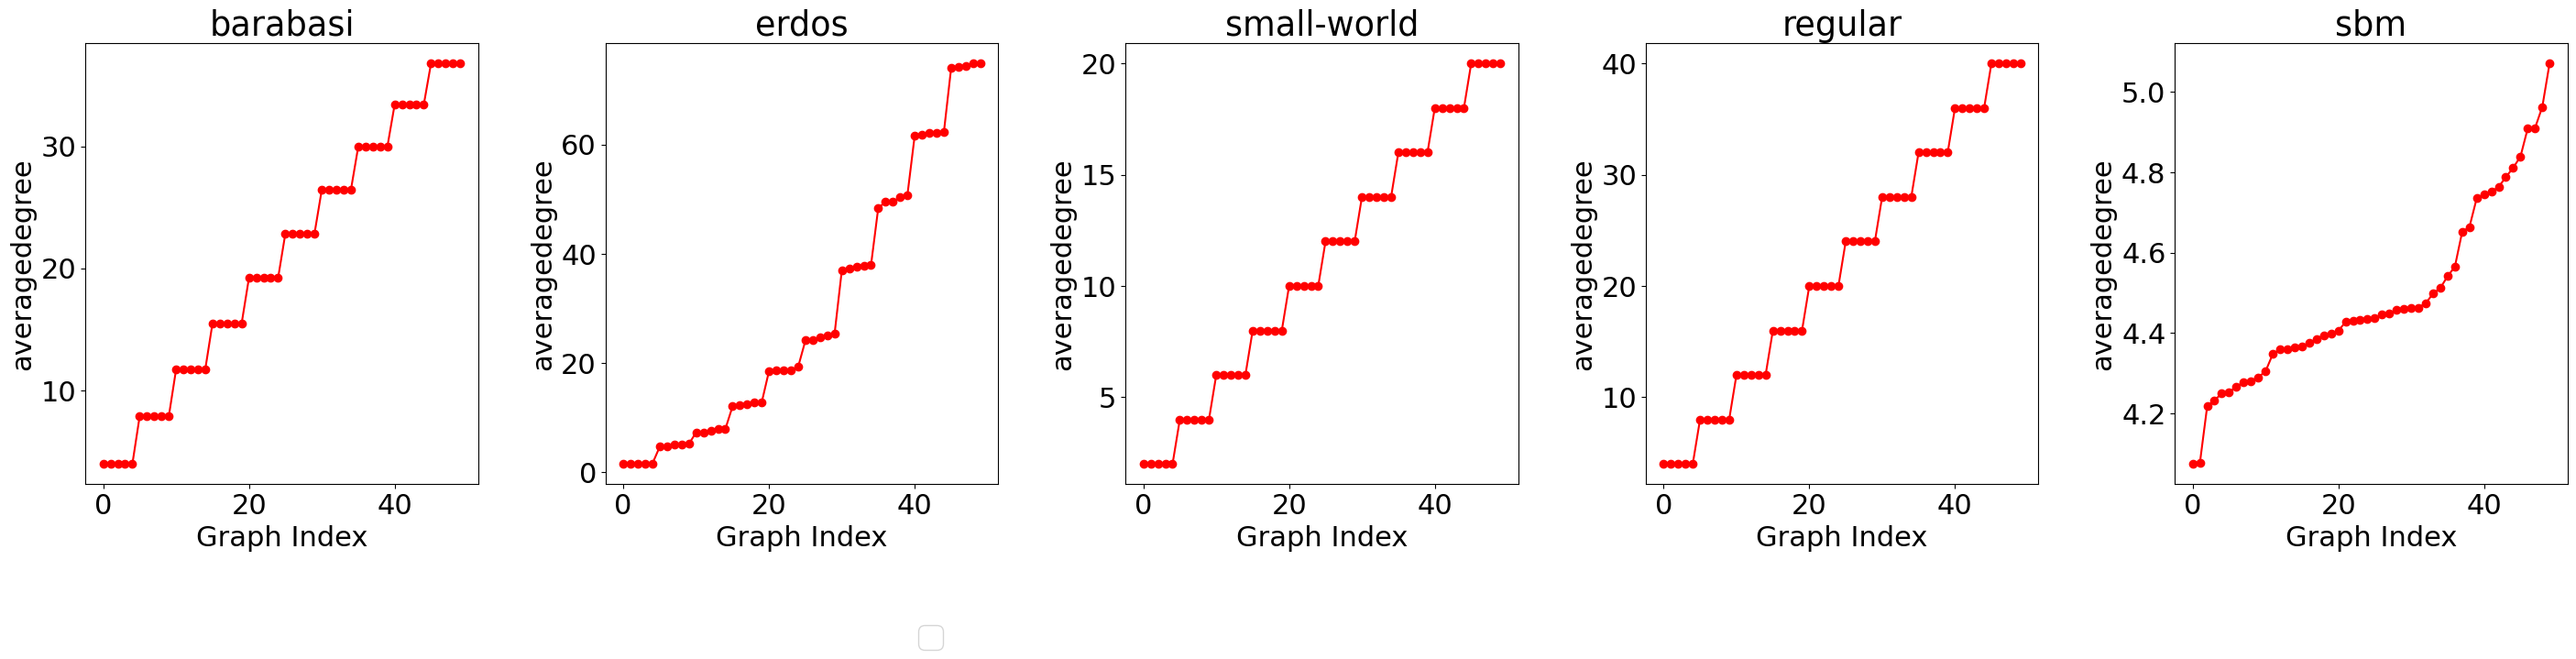

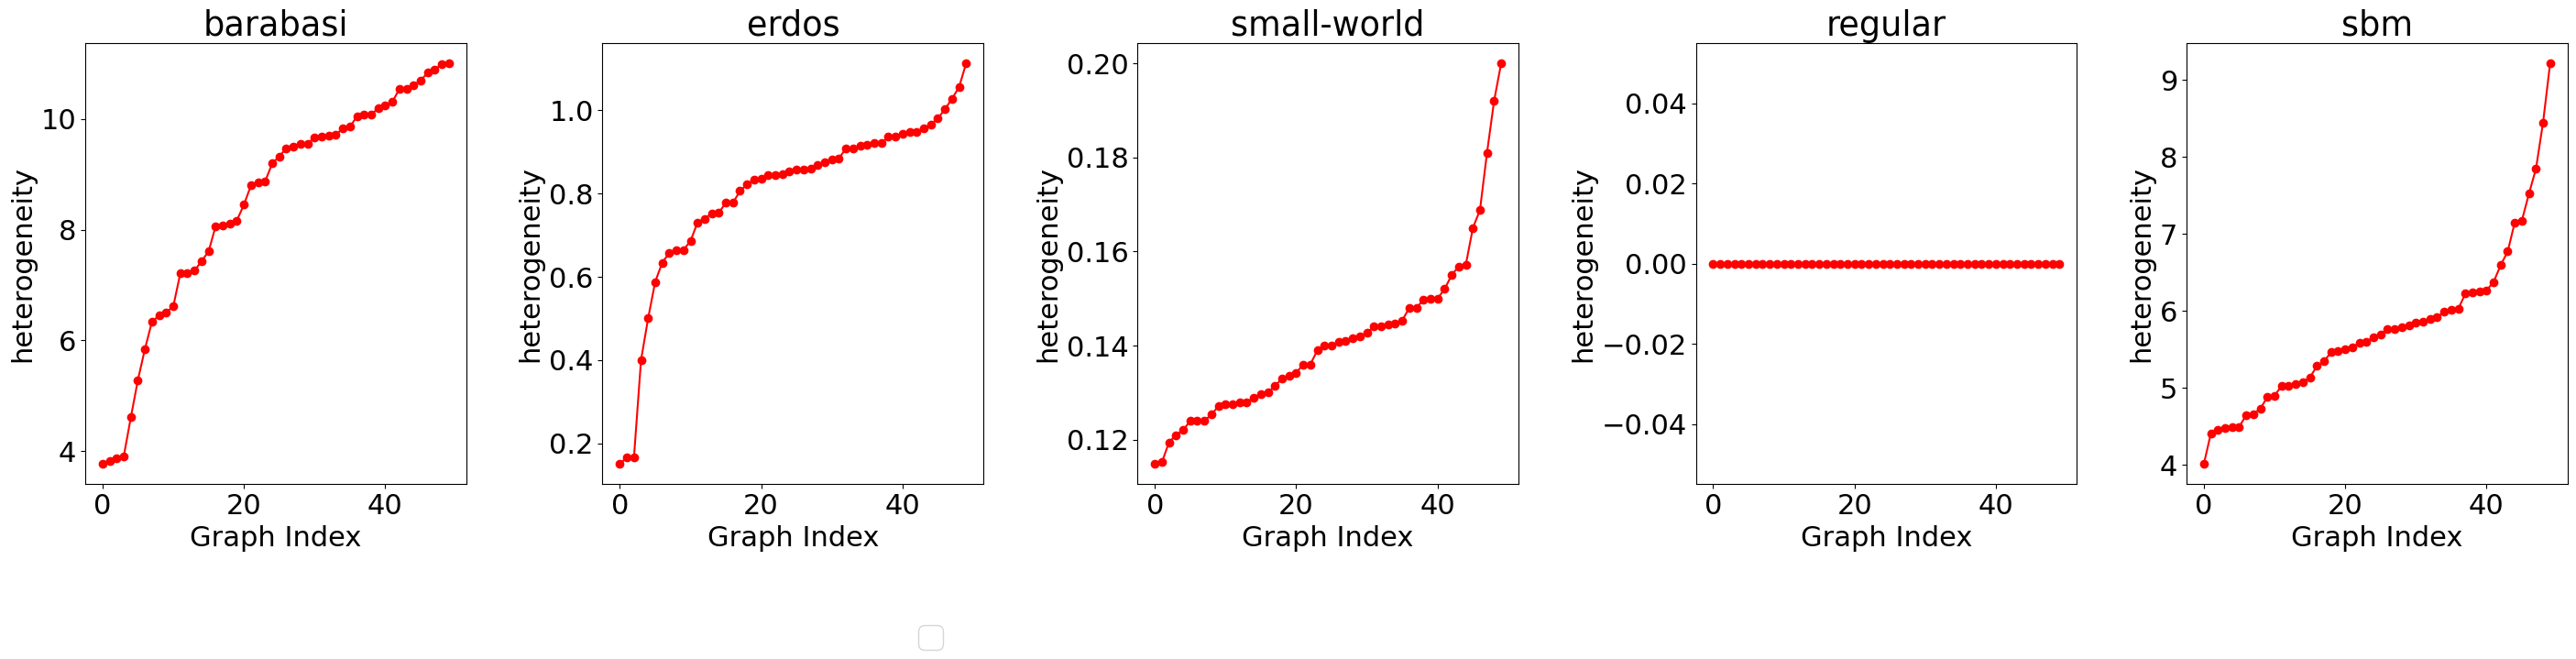

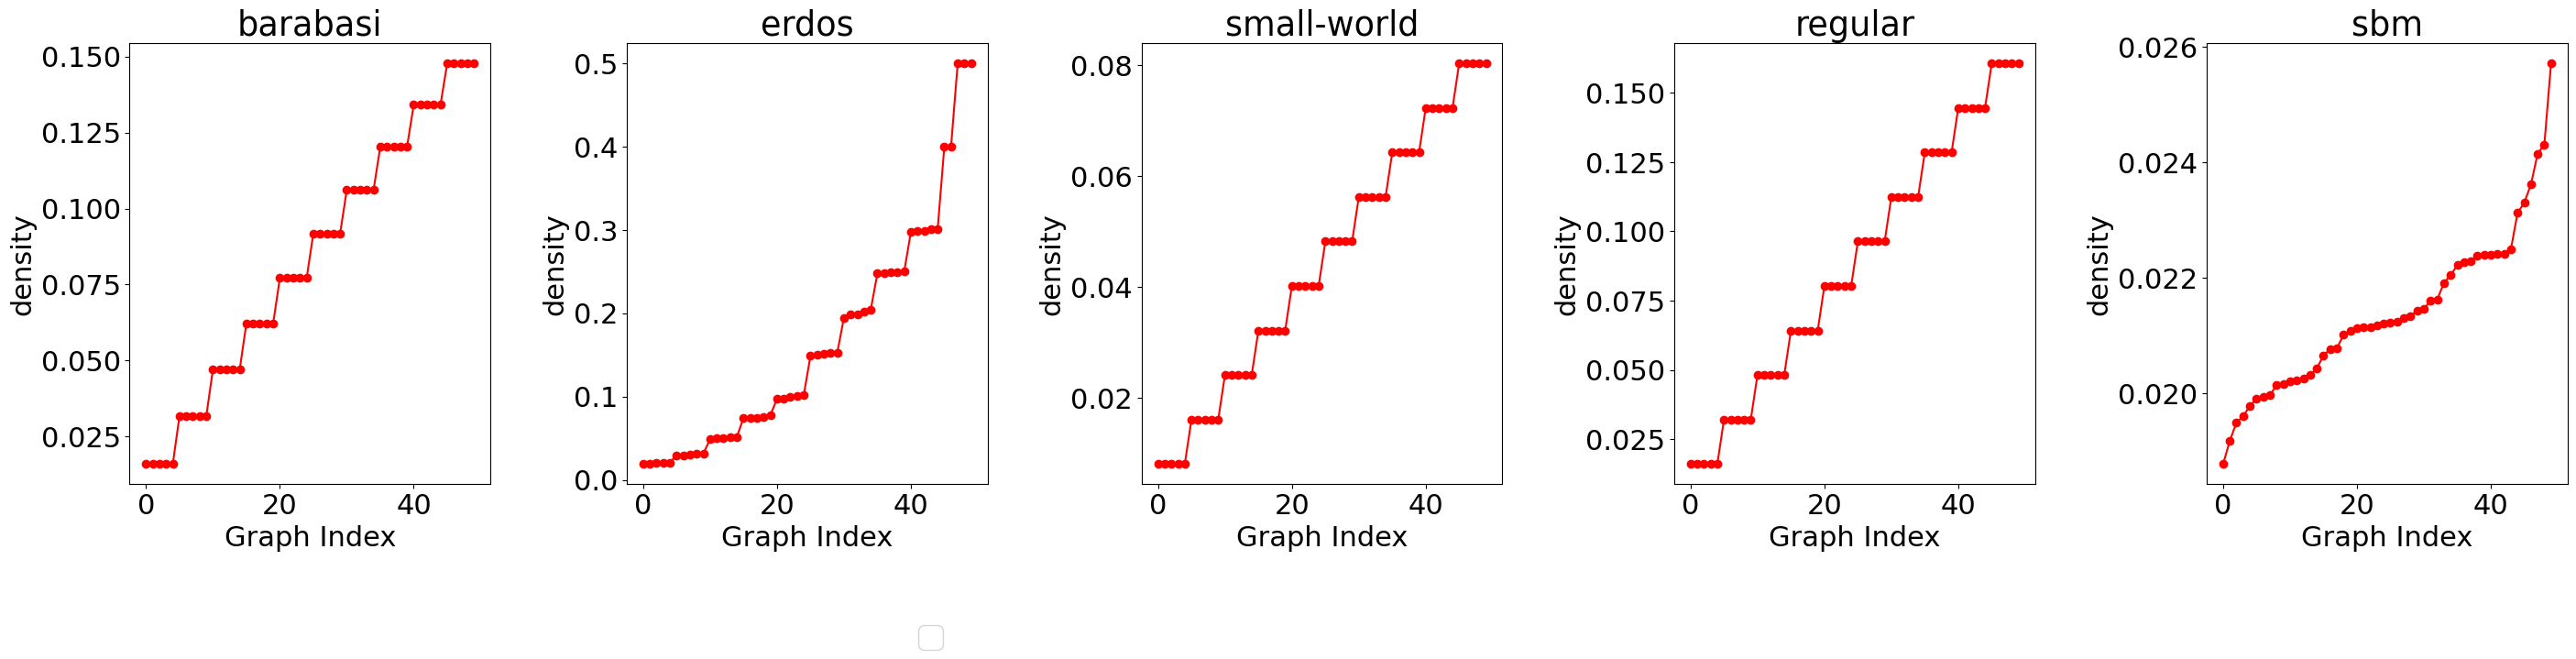

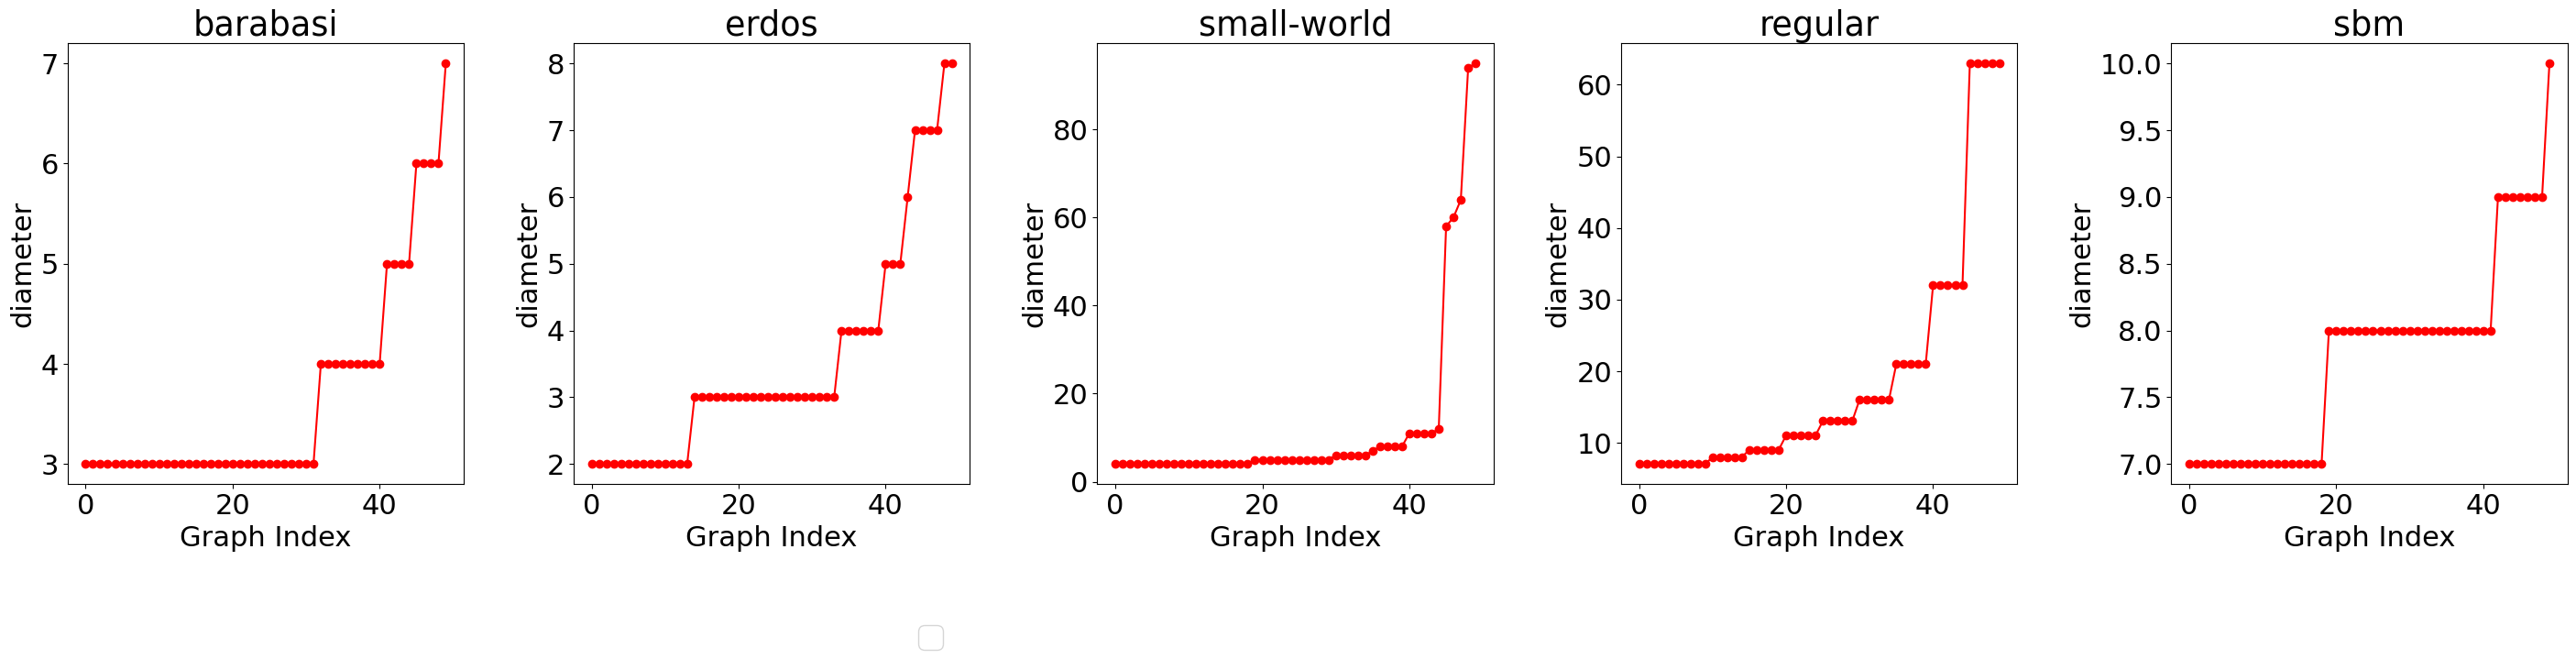

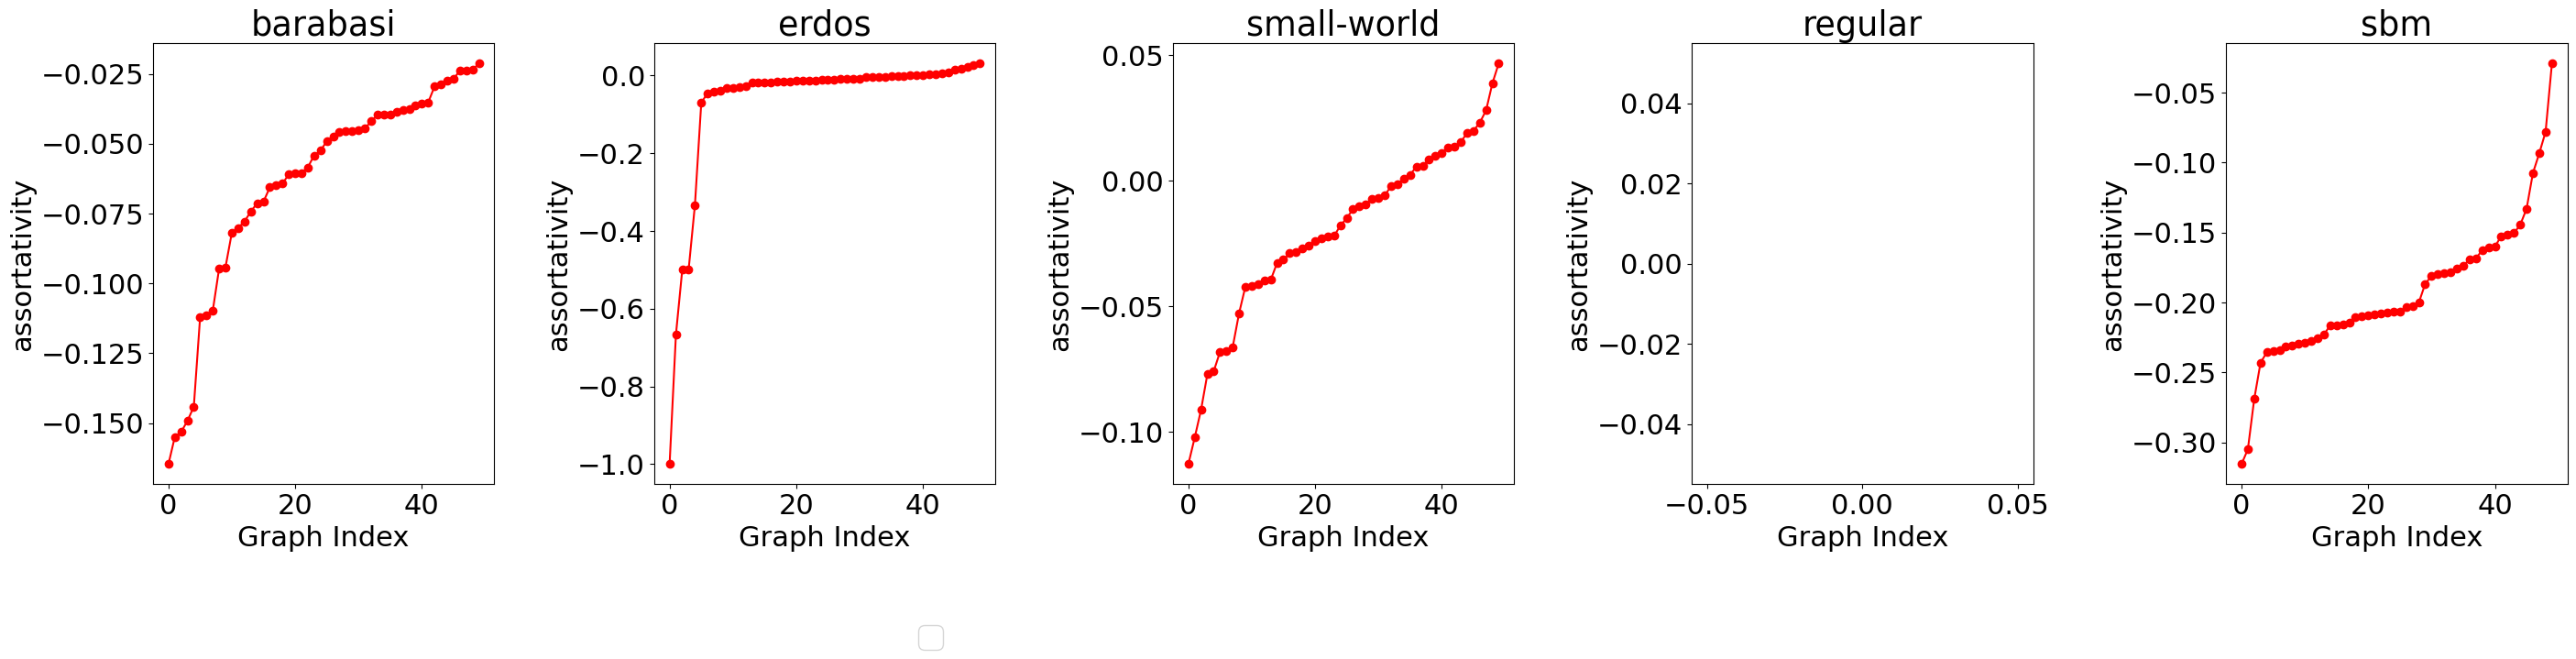

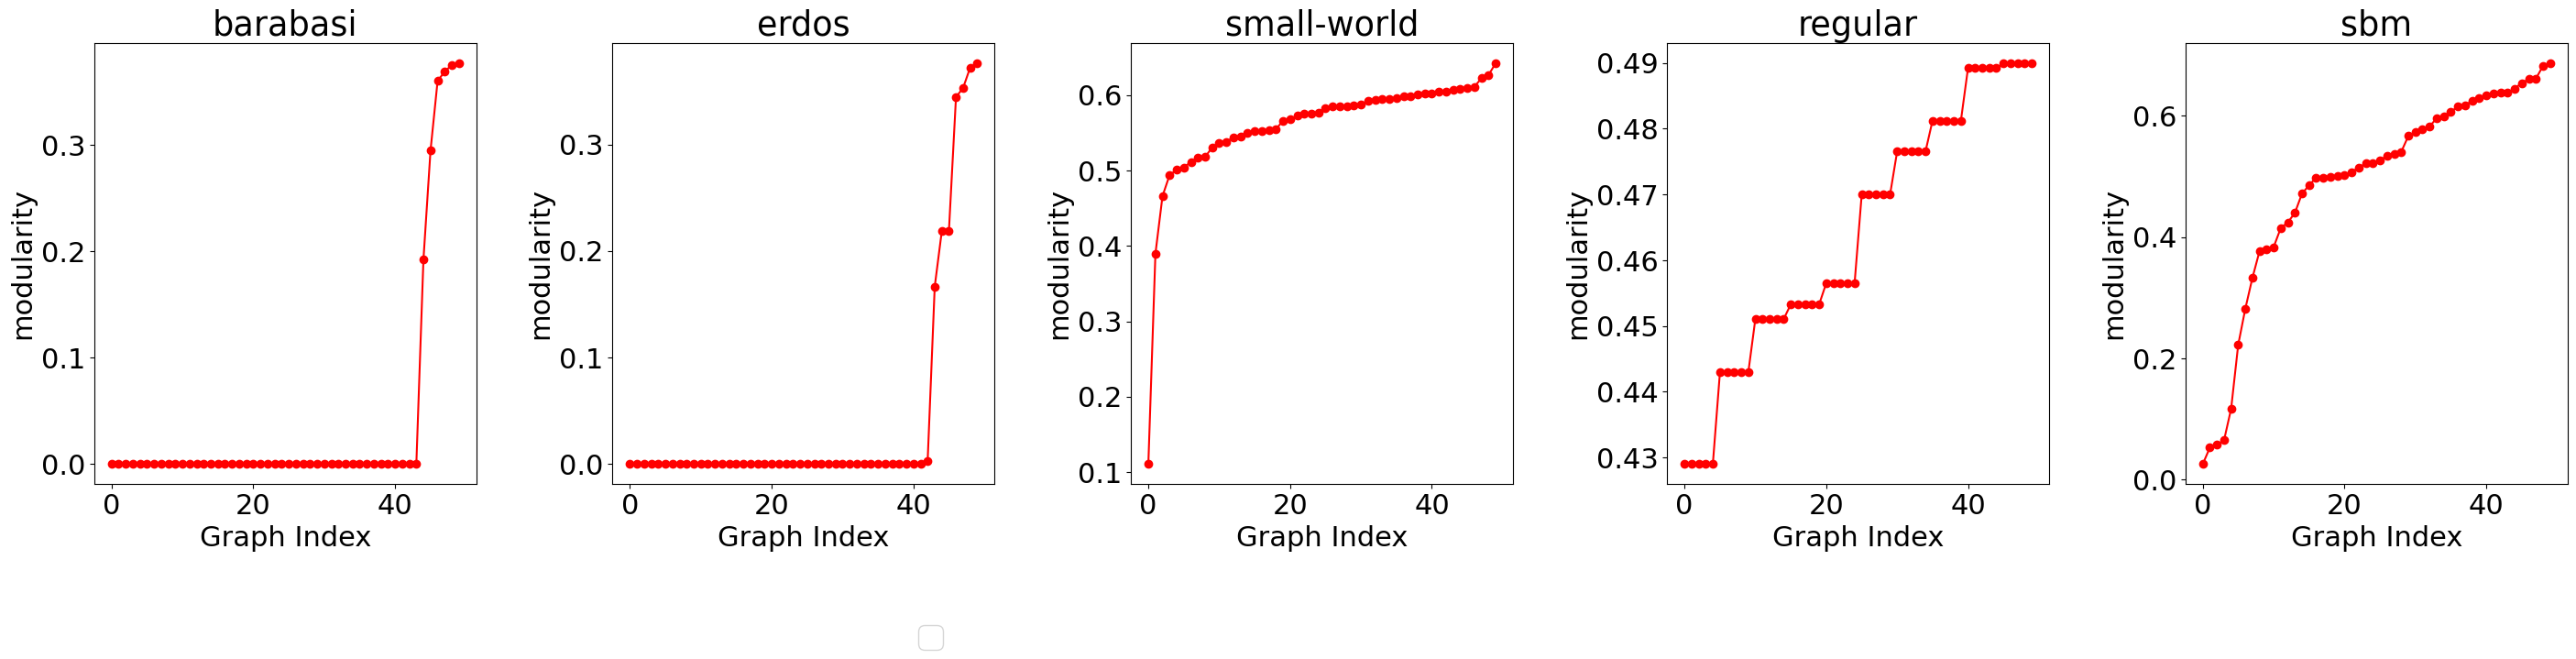

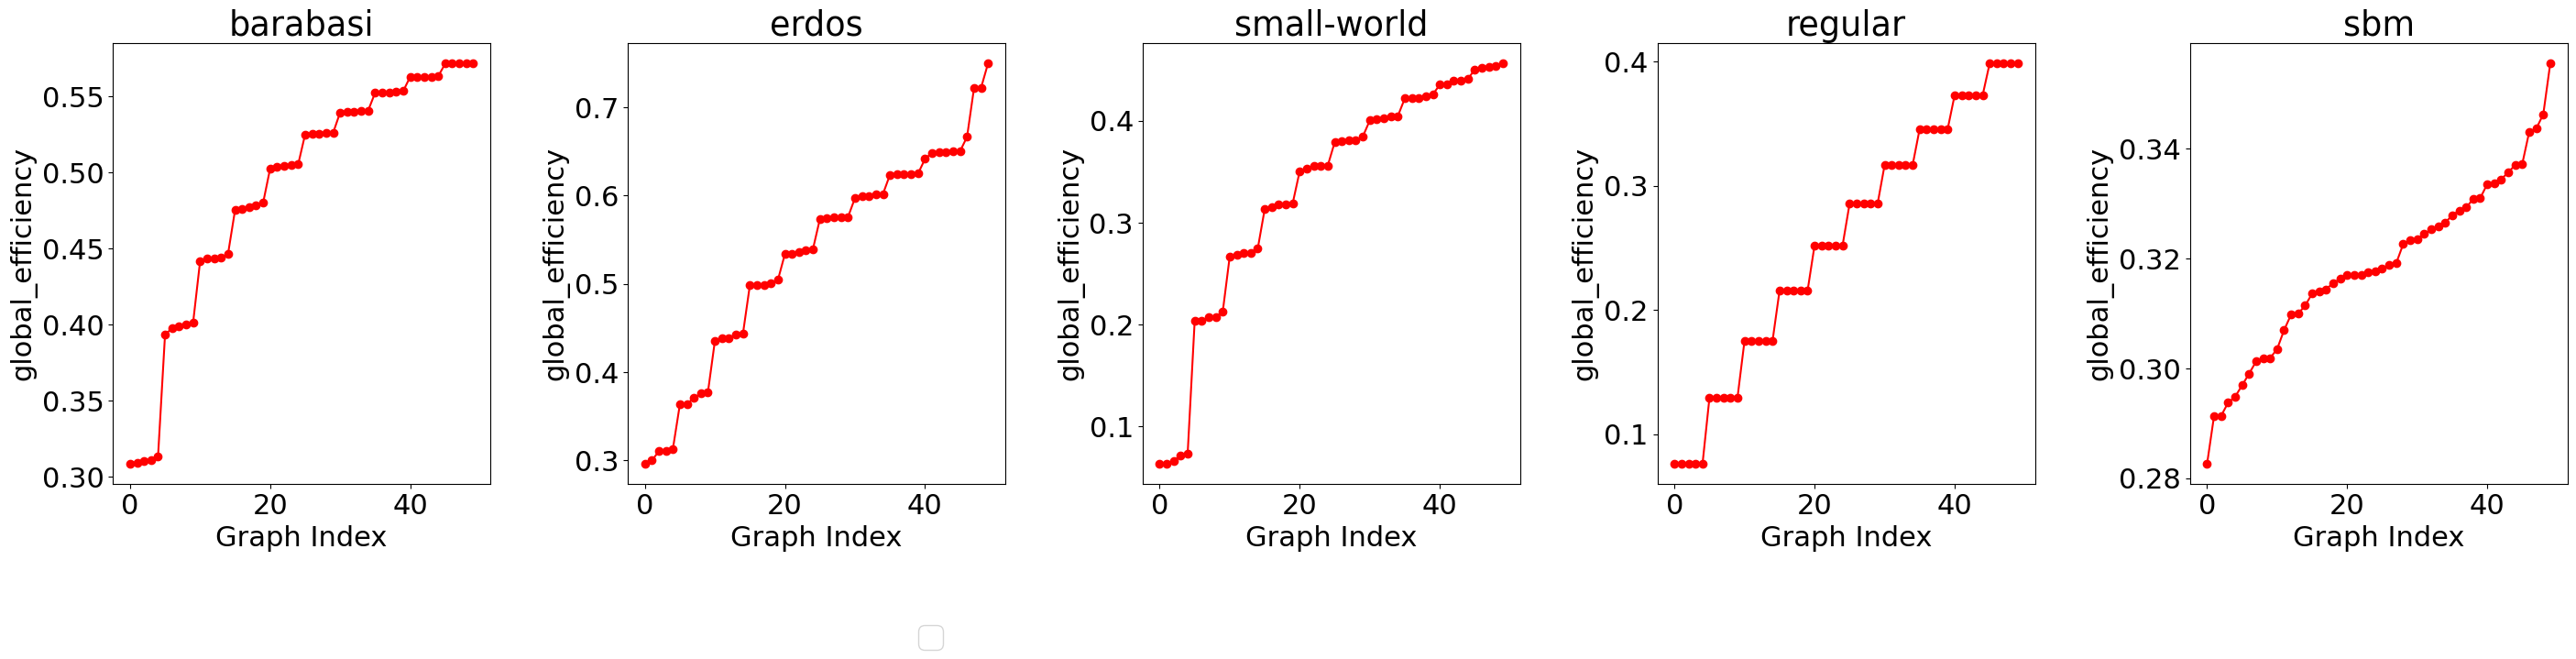

In [9]:
import matplotlib
def plot_feature_syn(feature, data, evalList):
    fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(28,6), dpi=100, constrained_layout=True, gridspec_kw={'wspace':0.1,'hspace':1.0})
    font = {'weight' : 'normal',
            'size'   : 22}
    matplotlib.rc('font', **font)
    for pos, randomgraph in enumerate(evalList):
        '''graph_path = "../Dataset/SyntheticGraph/Degree/New/"
        degree = [f.split(".txt")[0] for f in listdir(graph_path) if isfile(join(graph_path, f)) and f.split("_")[0] == randomgraph] 
        graph_path = "../Dataset/SyntheticGraph/Homogeneity/New/"
        homogeneity = [f.split(".txt")[0] for f in listdir(graph_path) if isfile(join(graph_path, f)) and f.split("_")[0] == randomgraph] 
        file_name = degree + homogeneity'''
        graph_path = "../Dataset/SyntheticGraph/New/"
        synthetic = [f.split(".txt")[0] for f in listdir(graph_path) if isfile(join(graph_path, f)) and f.split("_")[0] == randomgraph] 
        values_synthetic = []
        for f in synthetic:
            values_synthetic.append(data['synthetic'][f][feature])
        '''values_homo = []
        values_degree = []
        for f in degree:
            values_degree.append(data['degree'][f][feature])
        for f in homogeneity:
            values_homo.append(data['homogeneity'][f][feature])'''

        #plt.plot(values_all, color= "purple")
        #values_homo =sorted(values_homo)
        #values_degree = sorted(values_degree)
        values_synthetic = sorted(values_synthetic)
        ax[pos].plot(range(len(values_synthetic)),values_synthetic, color = "red", marker='o')
        #ax[pos].plot(range(len(values_degree)),values_degree, color = "red", label ="Degree", marker='o')
        #ax[pos].plot(range(len(values_homo)),values_homo, color = "blue", label ="Homogeneity", marker='^')
        ax[pos].set_ylabel(feature)
        ax[pos].set_xlabel("Graph Index")
        ax[pos].set_title(randomgraph)
    #plt.legend(loc="upper left", fontsize=24, bbox_to_anchor=(1,1))
    handles, labels = ax[pos].get_legend_handles_labels()
    fig.legend(handles, labels,loc = "lower left", bbox_to_anchor=(0.35, -0.2,1 ,1 ),markerscale=5,  fontsize=24, ncol = 2)
    title = feature
    plt.savefig("../Figure/Feature/Graph Feature/"+title+".png", bbox_inches='tight', pad_inches=0.1)
    plt.show()
feature_list= ["averagedegree","heterogeneity","density","resilience","eccentricity","diameter","assortativity"]
feature_list= ["averagedegree","heterogeneity","density",'diameter','assortativity','modularity',"global_efficiency"]
evalType =  ['barabasi', 'erdos','small-world','regular','sbm']
for f in feature_list:
    plot_feature_syn(f, feature, evalType)
        

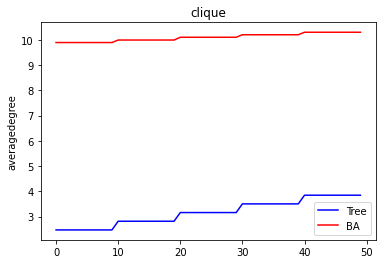

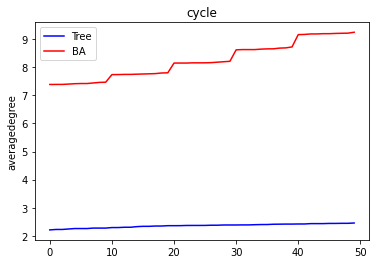

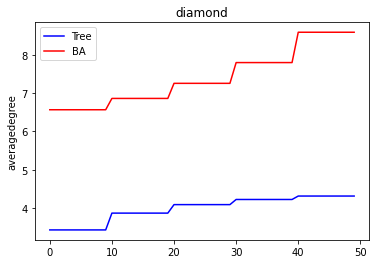

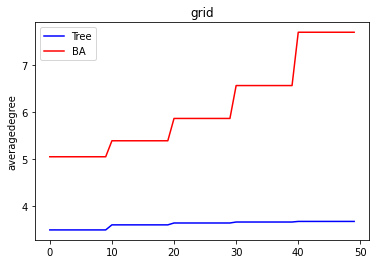

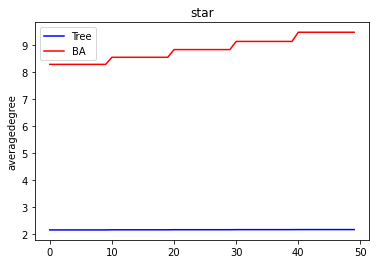

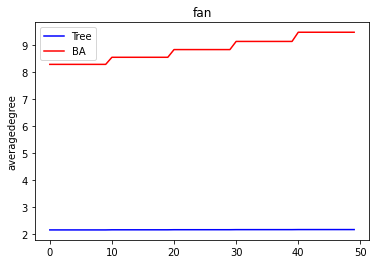

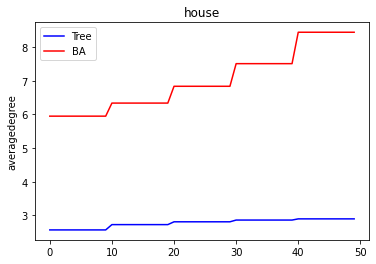

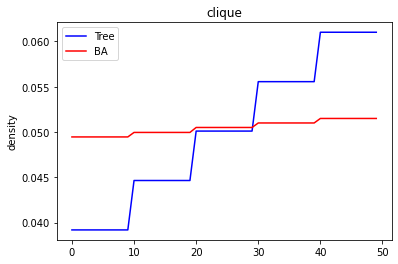

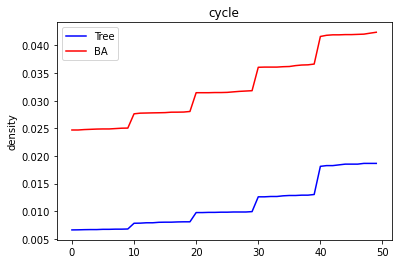

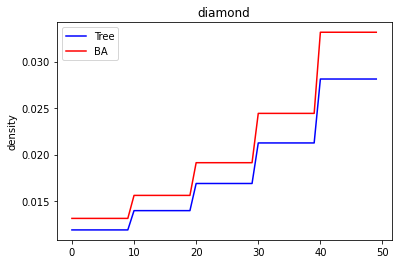

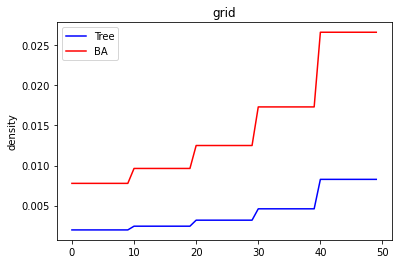

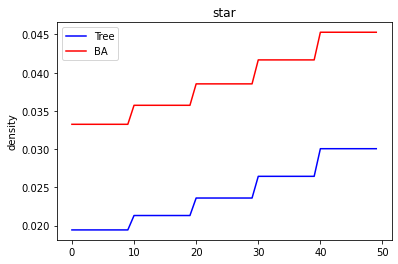

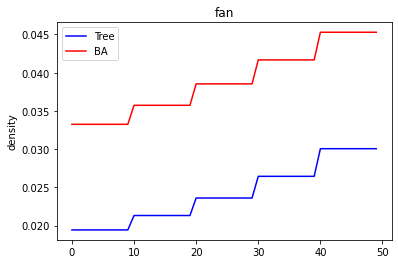

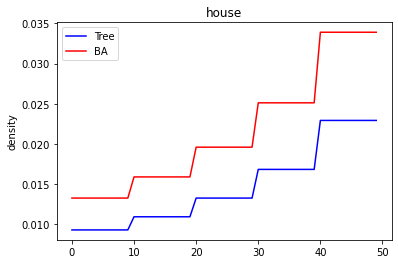

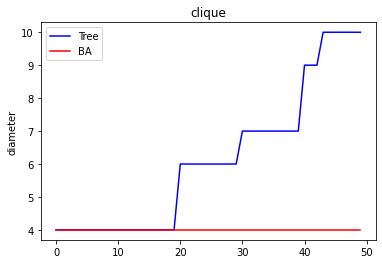

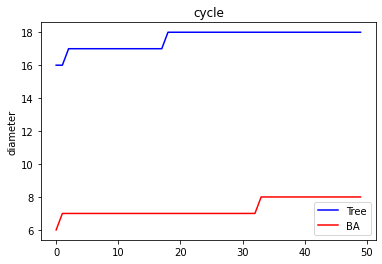

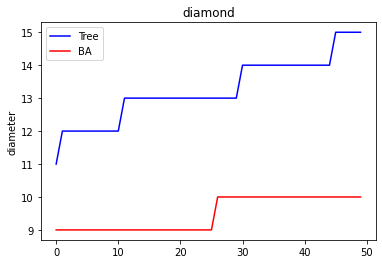

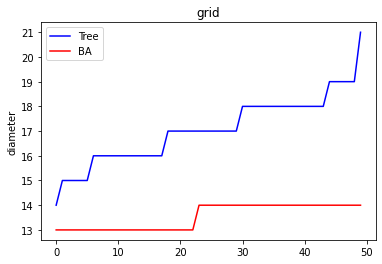

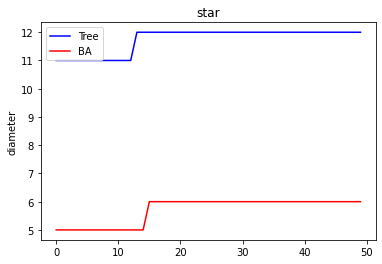

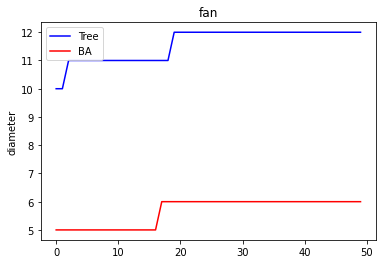

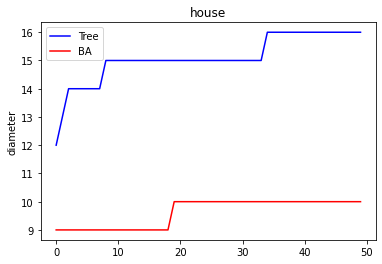

In [77]:
def plot_feature_synMotif(feature, data, motif):
    graph_path = "../Dataset/Motifs_Attached/New_BA"
    ba = [f for f in listdir(graph_path) if isfile(join(graph_path, f)) and f.split("_")[3] == motif] 
    graph_path = "../Dataset/Motifs_Attached/New_Tree"
    tree = [f for f in listdir(graph_path) if isfile(join(graph_path, f)) and f.split("_")[3] == motif] 
    file_name = ba + tree
    values_tree = []
    values_ba = []
    values_all = []
    for f in ba:
        values_ba.append(data[f][feature])
    for f in tree:
        values_tree.append(data[f][feature])
    for f in file_name:
        values_all.append(data[f][feature])
    values_ba =sorted(values_ba)
    values_tree = sorted(values_tree)
    #plt.plot(values_all, color= "purple")
    plt.plot(values_tree, color = "blue", label ="Tree")
    plt.plot(values_ba, color = "red", label ="BA")
    plt.ylabel(feature)
    plt.title(motif)
    plt.legend()
    plt.show()
feature_list= ["averagedegree","heterogeneity","density","resilience","eccentricity","diameter","assortativity"]
feature_list= ["averagedegree","density",'diameter']
#feature_list= ["averagedegree","assortativity", "density"]
for f in feature_list:
    plot_feature_synMotif(f, feature, "clique")
    plot_feature_synMotif(f, feature, "cycle")
    plot_feature_synMotif(f, feature, "diamond")
    plot_feature_synMotif(f, feature, "grid")
    plot_feature_synMotif(f, feature, "star")
    plot_feature_synMotif(f, feature, "fan")
    plot_feature_synMotif(f, feature, "house")

# Dump to JSON

In [ ]:
import json
with open("../Dataset/features.json", "w") as outfile:
    json.dump(feature, outfile)